In [1]:
# Required imports
import numpy as np
from TAVIE import *
import pandas as pd
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt

In [2]:
def renyi_divergence_laplace(mu1, tau1, mu2, tau2, alpha, *, atol=1e-12):
    """
    Compute D_alpha(P || Q): alpha-Renyi divergence where
      P ~ Laplace(mu1, tau1),  Q ~ Laplace(mu2, tau2),  tau1>0, tau2>0, 0 < alpha < 1.
    """
    b1 = 1 / tau1
    b2 = 1 / tau2
    
    if b1 <= 0 or b2 <= 0:
        raise ValueError("Scales b1 and b2 must be positive.")
    if alpha <= 0:
        raise ValueError("alpha must be > 0.")
    if np.isclose(alpha, 1.0, atol=atol):
        raise ValueError("alpha=1 is the KL case; not handled in this function.")

    Delta = abs(mu1 - mu2)
    a = alpha / b1
    c = (1.0 - alpha) / b2

    # Common factors
    pow_factor = (1.0 / (2.0 * b1)) ** alpha * (1.0 / (2.0 * b2)) ** (1.0 - alpha)
    e_c = np.exp(-c * Delta)
    e_a = np.exp(-a * Delta)

    denom_sum = a + c
    if np.isclose(denom_sum, 0.0, atol=atol):
        # In theory with b1,b2>0 and alpha>0 this won’t hit, but keep guard anyway.
        raise ValueError("Encountered a+c ≈ 0, expression undefined.")

    term1 = (e_c + e_a) / denom_sum

    # Handle the (a - c) denominator with continuity at a==c
    if np.isclose(a - c, 0.0, atol=atol):
        term2 = Delta * e_c   # limit as a -> c
    else:
        term2 = (e_c - e_a) / (a - c)

    Z = pow_factor * (term1 + term2)

    if Z <= 0 or not np.isfinite(Z):
        raise ValueError("Integral term became non-positive or non-finite; check inputs.")

    return (1.0 / (alpha - 1.0)) * np.log(Z)

# renyi_divergence_laplace(mu1 = 1, tau1 = 2, mu2 = 2, tau2 = 1, alpha=0.634)

In [3]:
def mean_Dalpha_vec(X, beta, beta0, tau, tau0, alpha):
    """
    Compute the mean alpha-Rényi divergence between elementwise Laplace(Xbeta[i], tau)
    and Laplace(Xbeta0[i], tau0), using the renyi_divergence_laplace() function.
    """
    Xbeta = (np.asarray(X) @ np.asarray(beta)).ravel()
    Xbeta0 = (np.asarray(X) @ np.asarray(beta0)).ravel()
    # if mu1_vec.shape != mu2_vec.shape:
    #     raise ValueError("mu1_vec and mu2_vec must have the same length")

    divergences = np.array([
        renyi_divergence_laplace(Xbeta[i], tau, Xbeta0[i], tau0, alpha)
        for i in range(len(Xbeta))
    ])
    return np.mean(divergences)

# mu1_vec=[1,2,3,4,5]
# mu2_vec=[6,7,8,9,10]
# tau1 = 2
# tau2 = 1
# alpha = 0.634

# mean_Dalpha_vec(mu1_vec, mu2_vec, tau1, tau2, alpha)



In [4]:
def sample_normal_gamma(mu, Sigma, a, b, N, rng=None):
    """
    Draw N samples from:
        tau2 ~ Gamma(shape=a/2, scale=2/b)
        beta | tau2 ~ N(mu, Sigma / tau2)
    """
    mu = np.asarray(mu, dtype=float)
    Sigma = np.asarray(Sigma, dtype=float)
    d = mu.shape[0]

    if rng is None:
        rng = np.random.default_rng()

    # 1) Draw tau^2 ~ Gamma(shape=a/2, scale=2/b)
    shape = a / 2.0
    scale = 2.0 / b
    tau2_samples = rng.gamma(shape=shape, scale=scale, size=N)  # (N,)

    # 2) Draw beta | tau^2
    # Cholesky of Sigma (d x d); Z ~ N(0, I_d)
    L = np.linalg.cholesky(Sigma)
    Z = rng.standard_normal(size=(N, d))
    # scale each row by 1/sqrt(tau2)
    inv_sqrt_tau2 = 1.0 / np.sqrt(tau2_samples)                 # (N,)
    beta_samples = mu + (Z @ L.T) * inv_sqrt_tau2[:, None]      # (N,d)

    return beta_samples, tau2_samples

In [5]:
def Dalpha_MC_integral(mu, Sigma, a, b, alpha, beta0, XX, tau0, N, rng=None):
    """
    Monte Carlo estimate of (1 - alpha) * E_beta[ Dalpha_beta_beta0(beta, beta0, XX, alpha, tau) ],
    where beta|tau2 ~ N(mu, Sigma/tau2) and tau2 ~ Gamma(shape = a/2, scale = 2/b).
    """
    mu    = np.asarray(mu, dtype=float)
    Sigma = np.asarray(Sigma, dtype=float)
    beta0 = np.asarray(beta0, dtype=float)
    XX    = np.asarray(XX, dtype=float)

    if rng is None:
        rng = np.random.default_rng()

    # Draw samples from the Normal–Gamma hierarchy
    beta_samples, tau2_samples = sample_normal_gamma(mu, Sigma, a, b, N, rng=rng)

    vals = []
    for beta_i, tau2_i in zip(beta_samples, tau2_samples):
        tau_i = np.sqrt(tau2_i)  # since we sampled tau^2
        vals.append(
            mean_Dalpha_vec(XX, beta_i, beta0, tau_i, tau0, alpha)
        )

    return (1.0 - alpha) * float(np.mean(vals))

In [12]:
# Simulated data
n = 10000
p = 5
tau2 = 8

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error = np.random.laplace(size=n, loc=0.0, scale = 1/np.sqrt(tau2))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for laplace likelihood
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
laplace_model.fit(X, y, alpha = 0.95, verbose=True) # fit the TAVIE model

# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = laplace_model.get_variational_estimates()


╭─ TAVIE Fit for laplace ─╮
│  Starting TAVIE fit!    │
╰─────────────────────────╯

Converged in 111 iterations.


In [13]:
variational_estimates

{'m_xi': array([-1.6764447 ,  0.9125881 ,  0.2193795 , -0.35839947, -1.09550828,
        -0.89517384]),
 'V_xi': array([[ 2.18824576e-05,  2.61515739e-07, -7.23716712e-07,
         -4.48507516e-07, -2.68945735e-07, -1.39620944e-06],
        [ 2.61515739e-07,  2.20729030e-05, -1.26284131e-07,
         -3.78615840e-07,  3.57710690e-07,  9.92391629e-08],
        [-7.23716712e-07, -1.26284131e-07,  2.21667678e-05,
          1.02113991e-07,  4.52660736e-07, -1.78946415e-07],
        [-4.48507516e-07, -3.78615840e-07,  1.02113991e-07,
          2.15921714e-05, -1.22414773e-06, -2.44133706e-07],
        [-2.68945735e-07,  3.57710690e-07,  4.52660736e-07,
         -1.22414773e-06,  2.28298502e-05, -1.43305740e-07],
        [-1.39620944e-06,  9.92391629e-08, -1.78946415e-07,
         -2.44133706e-07, -1.43305740e-07,  2.23728859e-05]]),
 'a_xi': 9500.05,
 'b_xi': np.float64(1217.053434269561)}

In [22]:
Dalpha_MC_integral(variational_estimates['m_xi'], variational_estimates['V_xi'], 
                   variational_estimates['a_xi'], variational_estimates['b_xi'], 
                   alpha = 0.95, beta0 = beta_true, XX = X_bbvi, tau0 = tau2, N = 100, rng=None)

0.03648782330398375

In [6]:
def choose_D_and_eps(C1, alpha, p, n, c=0.05, nudge=1e-12):
    # ---- Step 1: smallest feasible D
    const = (3 * (2**(2/3)) / c) ** 3  # ~ 864000 for c=0.05
    # ensure at least D=2
    D = max(2, 1 + int(np.ceil(np.sqrt(const / n))))

    # ---- Step 2: unconstrained minimizer for this D
    eps_star = np.sqrt((C1 * (p / n)) / (2.0 * D * alpha))

    # ---- Step 3: feasible interval from cubic 4 e^3 - c e^2 + 1/t = 0
    t = (D - 1.0) ** 2 * n
    coeffs = [4.0, -c, 0.0, 1.0 / t]
    roots = np.roots(coeffs)
    pos_real = sorted(r.real for r in roots if np.isreal(r) and r.real > 0)

    # If numerics return <2 positives (shouldn't happen), fall back to eps at g-minimum:
    if len(pos_real) < 2:
        eps_min = (1.0 / (2.0 * t)) ** (1.0 / 3.0)  # where g'(eps)=0
        # tiny nudge to satisfy strict inequality g(eps) < c
        return D, float(eps_min * (1 + 1e-12)), float(eps_star), (None, None)

    eps_low, eps_high = pos_real[0], pos_real[1]

    # Project eps_star into (eps_low, eps_high) and nudge off the boundary
    if eps_star <= eps_low:
        eps = np.nextafter(eps_low, eps_high)
    elif eps_star >= eps_high:
        eps = np.nextafter(eps_high, eps_low)
    else:
        eps = eps_star

    return D, float(eps)


# --- example (fill with your numbers) ---
# C1, alpha, p, n = 1.0, 0.5, 200, 5000
# D, eps, eps_star, interval = choose_D_and_eps(C1, alpha, p, n)
# print(f"D = {D}\nε* (unconstrained) = {eps_star:.6g}\nFeasible interval = {interval}\nChosen ε = {eps:.6g}")

In [7]:
from scipy.stats import gamma

def renyi_upper_bound_laplace(X, y, beta0, tau0, mu, Sigma, a, b, alpha):
    
    n, p = X.shape
    
    cons = 2
    E1 = 1
    E2 = 2
    E4 = 24
    
    K = 1
    M = np.max(1 / (4 * np.pow((np.sqrt(tau0) * (np.asarray(y) - np.asarray(X) @ np.asarray(beta0))).ravel(), 3))) + cons
    
    Q_tilde = 8 * max(1, K, K * E1, np.sqrt(M * E4), np.pow(M, 1/6), np.pow(M, 1/4), np.sqrt(M * E2))
    
    Q = np.max(np.linalg.norm(X, axis=1)) * max(tau0, 1 / (tau0 ** 2)) * Q_tilde
    
    diff = beta0 - mu
    Delta2 = float(diff.T @ np.linalg.solve(Sigma, diff))
    
    C = gamma.pdf(tau0, a=a/2, scale=2/b)

    
    Sigma_lambda_max = np.max(np.real(np.linalg.eigvals(Sigma)))
    
    C1 = 6 + np.log(np.sqrt(4 * Sigma_lambda_max) * (C / np.sqrt(tau0))) + ((tau0 + 1 / Q) * (Delta2 + 1 / (Q ** 2)))
    
    D, epsilon = choose_D_and_eps(C1, alpha, p, n, c=0.05, nudge=1e-12)
    
    bound = ((p * np.log(p)) / n) + (D * alpha * (epsilon ** 2)) + (C1 * (p / n) * np.log(1 / epsilon))
    
    return bound

In [31]:
n, p = X.shape
renyi_upper_bound_laplace(X_bbvi, y, beta_true, tau2, mu = np.zeros(p+1), Sigma = np.eye(p+1), a = 0.05, b = 0.05, 
                          alpha = 0.95)

np.float64(0.12998628838475762)

In [9]:
# Simulated data
n = 10000
p = 5
tau2 = 8

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error = np.random.laplace(size=n, loc=0.0, scale = 1/np.sqrt(tau2))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for laplace likelihood
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
laplace_model.fit(X, y, alpha = 0.95, verbose=True) # fit the TAVIE model

# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = laplace_model.get_variational_estimates()

integral = Dalpha_MC_integral(variational_estimates['m_xi'], variational_estimates['V_xi'], 
                   variational_estimates['a_xi'], variational_estimates['b_xi'], 
                   alpha = 0.95, beta0 = beta_true, XX = X_bbvi, tau0 = tau2, N = 100, rng=None)

bound = renyi_upper_bound_laplace(X_bbvi, y, beta_true, tau2, mu = np.zeros(p+1), Sigma = np.eye(p+1), a = 0.05, b = 0.05, 
                          alpha = 0.95)

print(integral, bound)

╭─ TAVIE Fit for laplace ─╮
│  Starting TAVIE fit!    │
╰─────────────────────────╯

Converged in 110 iterations.
0.03558178146691924 0.13913708933845212


# n = 10000, p = 8, Laplace, n_MC = 100, nreps = 50, tau2 = 8, alphas = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]

In [34]:
import time

# --------------------------
# User-configurable settings
# --------------------------
nreps  = 50
n      = 10_000
n_MC   = 100
p      = 8
tau2   = 8.0
alphas = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]
rng    = np.random.default_rng(2025)  # global RNG (reproducible)

# --------------------------
# Helper: one repetition
# --------------------------
def run_one_rep(alpha, n, p, tau2, rng):
    """
    Returns a dict with: alpha, integral, bound, runtime_fit, n, p, tau2.
    """
    t0 = time.time()

    # --- Simulate data ---
    X = rng.normal(size=(n, p))                   # (n,p)
    X_bbvi = np.column_stack([np.ones(n), X])     # add intercept
    beta_true = rng.normal(loc=0.0, scale=1.0, size=p+1)  # (p+1,)
    # Laplace noise with scale = 1/sqrt(tau2)
    error = rng.laplace(loc=0.0, scale=1.0/np.sqrt(tau2), size=n)
    y = beta_true[0] + X @ beta_true[1:] + error

    # --- Fit TAVIE Laplace model ---
    t_fit0 = time.time()
    laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
    laplace_model.fit(X, y, alpha=alpha, verbose=False)
    t_fit1 = time.time()
    runtime_fit = t_fit1 - t_fit0

    # --- Extract variational estimates ---
    variational_estimates = laplace_model.get_variational_estimates()
    # Expected keys: 'm_xi' (mean), 'V_xi' (cov), 'a_xi' (shape-like), 'b_xi' (rate/scale-like)

    # --- Monte Carlo integral ---
    integral = Dalpha_MC_integral(
        variational_estimates['m_xi'],
        variational_estimates['V_xi'],
        variational_estimates['a_xi'],
        variational_estimates['b_xi'],
        alpha=alpha,
        beta0=beta_true,
        XX=X_bbvi,
        tau0=np.sqrt(tau2),   # NOTE: if your mean_Dalpha_vec expects Laplace SCALE, use sqrt(tau2)
        N=n_MC,
        rng=rng
    )

    # --- Rényi upper bound (your function) ---
    bound = renyi_upper_bound_laplace(
        X_bbvi, y, beta_true, tau2,
        mu=np.zeros(p+1),
        Sigma=np.eye(p+1),
        a=0.05, b=0.05,
        alpha=alpha
    )

    return {
        "alpha": alpha,
        "integral": float(integral),
        "bound": float(bound),
        "runtime_fit": float(runtime_fit),
        "n": n,
        "p": p,
        "tau2": float(tau2),
    }

# --------------------------
# Main simulation loop
# --------------------------
records = []
for alpha in alphas:
    for rep in range(1, nreps + 1):
        rec = run_one_rep(alpha, n, p, tau2, rng)
        rec["rep"] = rep
        records.append(rec)

results = pd.DataFrame.from_records(records)

# Per-alpha summary
summary = (
    results
    .groupby("alpha", as_index=False)
    .agg(mean_integral=("integral", "mean"),
         sd_integral=("integral", "std"),
         mean_bound=("bound", "mean"),
         sd_bound=("bound", "std"),
         mean_runtime_fit=("runtime_fit", "mean"))
    .sort_values("alpha")
)

# (Optional) print a compact report
print("\nPer-alpha summary:")
print(summary.to_string(index=False))

# You now have:
# - 'results': one row per rep per alpha
# - 'summary': averages and std devs by alpha

results.to_pickle("results_theory/results_Laplace_theory_alpha_less_1.pkl")
summary.to_pickle("results_theory/summary_Laplace_theory_alpha_less_1.pkl")



Per-alpha summary:
 alpha  mean_integral  sd_integral  mean_bound  sd_bound  mean_runtime_fit
  0.20       0.000283     0.000094    0.284249  0.120679          0.092933
  0.30       0.000291     0.000119    0.299837  0.168487          0.098464
  0.40       0.000246     0.000068    0.285044  0.154307          0.102419
  0.60       0.000197     0.000070    0.302994  0.180497          0.112942
  0.80       0.000122     0.000050    0.303054  0.120605          0.111287
  0.95       0.000029     0.000012    0.283031  0.127247          0.119062


/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_33559/2847293482.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


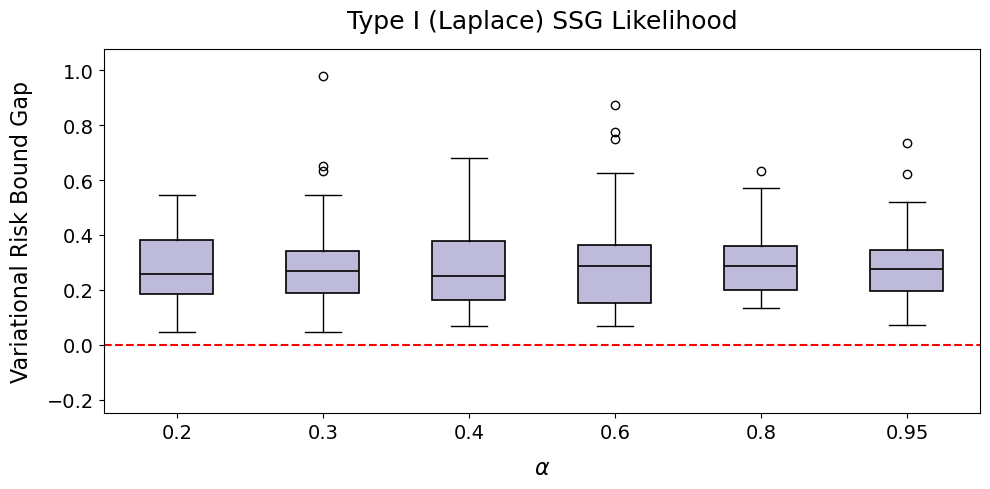

In [38]:
df = results.copy()
df["diff"] = df["bound"] - df["integral"]

# Sort alphas for consistent ordering
alphas = np.sort(df["alpha"].unique())
data_by_alpha = [df.loc[df["alpha"] == a, "diff"].to_numpy() for a in alphas]

# Font sizes
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data_by_alpha,
    labels=[str(a) for a in alphas],
    showfliers=True,
    patch_artist=True
)

# Light blue fill
for box in bp['boxes']:
    box.set(facecolor="#BEBADA", edgecolor="black", linewidth=1.2)

# Bold black medians
for median in bp['medians']:
    median.set(color="black", linewidth=1.2)

# Red dashed reference line at 0
ax.axhline(0, color="red", linestyle="--", linewidth=1.5)

ymin = min(np.concatenate(data_by_alpha))
ymax = max(np.concatenate(data_by_alpha))
pad = 0.1 * max(abs(ymin), abs(ymax))  # 10% padding
lim = max(abs(ymin), abs(ymax)) + pad
ax.set_ylim(-0.25, lim)

# Axis labels and title with larger fonts
ax.set_xlabel(r"$\alpha$", fontsize=label_fontsize, labelpad=10)
ax.set_ylabel(r"Variational Risk Bound Gap", fontsize=label_fontsize, labelpad=10)
ax.set_title(r"Type I (Laplace) SSG Likelihood", fontsize=title_fontsize, pad=15)

# Tick label size
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

fig.tight_layout()

# Save figure
fig.savefig("results_theory/variational_risk_bound_gap.png", dpi=300, bbox_inches='tight')

plt.show()


# n = 2000, p = 8, Laplace, n_MC = 100, nreps = 50, tau2 = 8, alphas = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]

In [39]:
import time

# --------------------------
# User-configurable settings
# --------------------------
nreps  = 50
n      = 2000
n_MC   = 100
p      = 8
tau2   = 8.0
alphas = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]
rng    = np.random.default_rng(2025)  # global RNG (reproducible)

# --------------------------
# Helper: one repetition
# --------------------------
def run_one_rep(alpha, n, p, tau2, rng):
    """
    Returns a dict with: alpha, integral, bound, runtime_fit, n, p, tau2.
    """
    t0 = time.time()

    # --- Simulate data ---
    X = rng.normal(size=(n, p))                   # (n,p)
    X_bbvi = np.column_stack([np.ones(n), X])     # add intercept
    beta_true = rng.normal(loc=0.0, scale=1.0, size=p+1)  # (p+1,)
    # Laplace noise with scale = 1/sqrt(tau2)
    error = rng.laplace(loc=0.0, scale=1.0/np.sqrt(tau2), size=n)
    y = beta_true[0] + X @ beta_true[1:] + error

    # --- Fit TAVIE Laplace model ---
    t_fit0 = time.time()
    laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
    laplace_model.fit(X, y, alpha=alpha, verbose=False)
    t_fit1 = time.time()
    runtime_fit = t_fit1 - t_fit0

    # --- Extract variational estimates ---
    variational_estimates = laplace_model.get_variational_estimates()
    # Expected keys: 'm_xi' (mean), 'V_xi' (cov), 'a_xi' (shape-like), 'b_xi' (rate/scale-like)

    # --- Monte Carlo integral ---
    integral = Dalpha_MC_integral(
        variational_estimates['m_xi'],
        variational_estimates['V_xi'],
        variational_estimates['a_xi'],
        variational_estimates['b_xi'],
        alpha=alpha,
        beta0=beta_true,
        XX=X_bbvi,
        tau0=np.sqrt(tau2),   # NOTE: if your mean_Dalpha_vec expects Laplace SCALE, use sqrt(tau2)
        N=n_MC,
        rng=rng
    )

    # --- Rényi upper bound (your function) ---
    bound = renyi_upper_bound_laplace(
        X_bbvi, y, beta_true, tau2,
        mu=np.zeros(p+1),
        Sigma=np.eye(p+1),
        a=0.05, b=0.05,
        alpha=alpha
    )

    return {
        "alpha": alpha,
        "integral": float(integral),
        "bound": float(bound),
        "runtime_fit": float(runtime_fit),
        "n": n,
        "p": p,
        "tau2": float(tau2),
    }

# --------------------------
# Main simulation loop
# --------------------------
records = []
for alpha in alphas:
    for rep in range(1, nreps + 1):
        rec = run_one_rep(alpha, n, p, tau2, rng)
        rec["rep"] = rep
        records.append(rec)

results = pd.DataFrame.from_records(records)

# Per-alpha summary
summary = (
    results
    .groupby("alpha", as_index=False)
    .agg(mean_integral=("integral", "mean"),
         sd_integral=("integral", "std"),
         mean_bound=("bound", "mean"),
         sd_bound=("bound", "std"),
         mean_runtime_fit=("runtime_fit", "mean"))
    .sort_values("alpha")
)

# (Optional) print a compact report
print("\nPer-alpha summary:")
print(summary.to_string(index=False))

# You now have:
# - 'results': one row per rep per alpha
# - 'summary': averages and std devs by alpha

results.to_pickle(f"results_theory/results_Laplace_theory_alpha_less_1_n_{n}_p_{p}.pkl")
summary.to_pickle(f"results_theory/summary_Laplace_theory_alpha_less_1_n_{n}_p_{p}.pkl")



Per-alpha summary:
 alpha  mean_integral  sd_integral  mean_bound  sd_bound  mean_runtime_fit
  0.20       0.002714     0.001918    1.486088  0.966063          0.014834
  0.30       0.002344     0.001024    1.624540  0.751379          0.015565
  0.40       0.001872     0.000805    1.575698  0.680653          0.017025
  0.60       0.001342     0.000548    1.515838  0.647190          0.018871
  0.80       0.000735     0.000244    1.583018  0.681874          0.020240
  0.95       0.000188     0.000070    1.394988  0.655544          0.021039


/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_33559/886642331.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


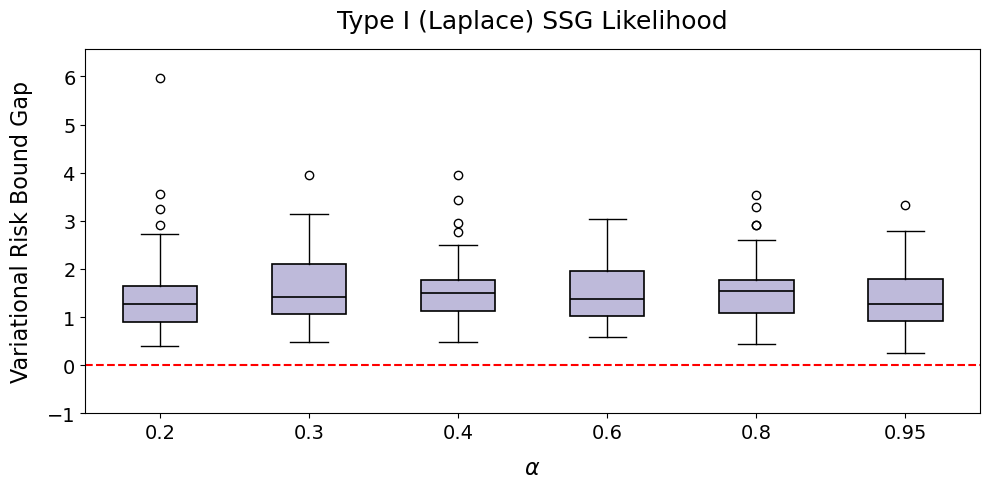

In [43]:
df = results.copy()
df["diff"] = df["bound"] - df["integral"]

# Sort alphas for consistent ordering
alphas = np.sort(df["alpha"].unique())
data_by_alpha = [df.loc[df["alpha"] == a, "diff"].to_numpy() for a in alphas]

# Font sizes
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data_by_alpha,
    labels=[str(a) for a in alphas],
    showfliers=True,
    patch_artist=True
)

# Light blue fill
for box in bp['boxes']:
    box.set(facecolor="#BEBADA", edgecolor="black", linewidth=1.2)

# Bold black medians
for median in bp['medians']:
    median.set(color="black", linewidth=1.2)

# Red dashed reference line at 0
ax.axhline(0, color="red", linestyle="--", linewidth=1.5)

ymin = min(np.concatenate(data_by_alpha))
ymax = max(np.concatenate(data_by_alpha))
pad = 0.1 * max(abs(ymin), abs(ymax))  # 10% padding
lim = max(abs(ymin), abs(ymax)) + pad
ax.set_ylim(-1, lim)

# Axis labels and title with larger fonts
ax.set_xlabel(r"$\alpha$", fontsize=label_fontsize, labelpad=10)
ax.set_ylabel(r"Variational Risk Bound Gap", fontsize=label_fontsize, labelpad=10)
ax.set_title(r"Type I (Laplace) SSG Likelihood", fontsize=title_fontsize, pad=15)

# Tick label size
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

fig.tight_layout()

# Save figure
fig.savefig(f"results_theory/variational_risk_bound_gap_Laplace_n_{n}_p_{p}.png", dpi=300, bbox_inches='tight')

plt.show()


# For Negative-Binomial

In [85]:
# Required imports
import numpy as np
from TAVIE import *
import pandas as pd
import rich
import time
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt

### $\alpha$-Renyi Divergence and Variational Integrated Risk

In [86]:
def renyi_divergence_nb_equal_r(r, p1, p2, alpha):
    z = (1 - p1)**alpha * (1 - p2)**(1 - alpha)
    num = 1 - z
    den = (p1 ** alpha) * (p2 ** (1-alpha))
    A = -np.log(num / den)
    return ((r / (alpha-1)) * A)

def mean_Dalpha_vec_nb(X, r, beta, beta0, alpha):
    Xbeta = (np.asarray(X) @ np.asarray(beta)).ravel()
    Xbeta0 = (np.asarray(X) @ np.asarray(beta0)).ravel()
    
    p = 1 / (1 + np.exp(-Xbeta))
    p0 = 1 / (1 + np.exp(-Xbeta0))
    # if mu1_vec.shape != mu2_vec.shape:
    #     raise ValueError("mu1_vec and mu2_vec must have the same length")

    divergences = np.array([
        renyi_divergence_nb_equal_r(r[i], p[i], p0[i], alpha)
        for i in range(len(Xbeta))
    ])
    return np.mean(divergences)


def Dalpha_MC_integral_nb(mu, Sigma, alpha, r, beta0, XX, N, rng=None):
    mu    = np.asarray(mu, dtype=float)
    Sigma = np.asarray(Sigma, dtype=float)
    beta0 = np.asarray(beta0, dtype=float)
    XX    = np.asarray(XX, dtype=float)

    if rng is None:
        rng = np.random.default_rng()

    # Draw samples from the Normal
    beta_samples = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
    vals = []
    for beta_i in beta_samples:
        vals.append(
            mean_Dalpha_vec_nb(XX, r*np.ones(XX.shape[0]), beta_i, beta0, alpha)
        )

    return (1.0 - alpha) * float(np.mean(vals))

### Variational Risk bound for optimal $D$ and $\varepsilon$

In [87]:
def choose_D_and_eps(C1, alpha, p, n, c=0.05, nudge=1e-12):
    # ---- Step 1: smallest feasible D
    const = (3 * (2**(2/3)) / c) ** 3  # ~ 864000 for c=0.05
    # ensure at least D=2
    D = max(2, 1 + int(np.ceil(np.sqrt(const / n))))

    # ---- Step 2: unconstrained minimizer for this D
    eps_star = np.sqrt((C1 * (p / n)) / (2.0 * D * alpha))

    # ---- Step 3: feasible interval from cubic 4 e^3 - c e^2 + 1/t = 0
    t = (D - 1.0) ** 2 * n
    coeffs = [4.0, -c, 0.0, 1.0 / t]
    roots = np.roots(coeffs)
    pos_real = sorted(r.real for r in roots if np.isreal(r) and r.real > 0)

    # If numerics return <2 positives (shouldn't happen), fall back to eps at g-minimum:
    if len(pos_real) < 2:
        eps_min = (1.0 / (2.0 * t)) ** (1.0 / 3.0)  # where g'(eps)=0
        # tiny nudge to satisfy strict inequality g(eps) < c
        return D, float(eps_min * (1 + 1e-12)), float(eps_star), (None, None)

    eps_low, eps_high = pos_real[0], pos_real[1]

    # Project eps_star into (eps_low, eps_high) and nudge off the boundary
    if eps_star <= eps_low:
        eps = np.nextafter(eps_low, eps_high)
    elif eps_star >= eps_high:
        eps = np.nextafter(eps_high, eps_low)
    else:
        eps = eps_star

    return D, float(eps)


def renyi_upper_bound_nb(X, r, beta0, mu, Sigma, alpha):
    
    n, p = X.shape
    
    X2_inf = np.max(np.linalg.norm(X, axis=1))
    beta0_l2 = np.linalg.norm(beta0)
    
    Q = max(4 * X2_inf, 8 * (X2_inf ** 2) * beta0_l2) * r * (1 + np.exp(X2_inf * beta0_l2))
    
    diff = beta0 - mu
    Delta2 = float(diff.T @ np.linalg.solve(Sigma, diff))
    
    Sigma_lambda_max = max(np.real(np.linalg.eigvals(Sigma)))
    
    C1 = 0.5 * (8 + np.log(2) + np.log(Sigma_lambda_max) + 2 * np.log(Q) + Delta2  + (1 / (Sigma_lambda_max * (Q ** 2))))
    
    D, epsilon = choose_D_and_eps(C1, alpha, p, n, c=0.05, nudge=1e-12)
    
    bound = ((p * np.log(p)) / n) + (D * alpha * (epsilon ** 2)) + (C1 * (p / n) * np.log(1 / epsilon))
    
    return bound

### Experiment

In [91]:
# Experiment parameters
n = 1000
p = 5
r = 10
alpha = 0.95
# num_reps = 100
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)
X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
probs = 1 / (1 + np.exp(-linear_term))
y = np.random.negative_binomial(r, probs, size=n)

negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)
negbin_tavie_model.fit(X, y, r=r, alpha = alpha, verbose=False) # fitting the TAVIE model for laplace
beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
variational_estimates = negbin_tavie_model.get_variational_estimates()

integrated_risk = Dalpha_MC_integral_nb(variational_estimates['m_xi'], variational_estimates['V_xi'], alpha=alpha, 
                      r = 10, beta0 = beta_true, XX = X_bbvi, N=1000, rng=None)
bound = renyi_upper_bound_nb(X_bbvi, 10, beta_true, variational_estimates['m_xi'],  variational_estimates['V_xi'], alpha)

print(f"Integrated Risk: {integrated_risk}; Bound: {bound}")

Integrated Risk: 0.00030488312322823506; Bound: 0.6840169835722867


### Multi alpha setup

alpha = 0.2, rep = 1
alpha = 0.2, rep = 2
alpha = 0.2, rep = 3
alpha = 0.2, rep = 4
alpha = 0.2, rep = 5
alpha = 0.2, rep = 6
alpha = 0.2, rep = 7
alpha = 0.2, rep = 8
alpha = 0.2, rep = 9
alpha = 0.2, rep = 10
alpha = 0.2, rep = 11
alpha = 0.2, rep = 12
alpha = 0.2, rep = 13
alpha = 0.2, rep = 14
alpha = 0.2, rep = 15
alpha = 0.2, rep = 16
alpha = 0.2, rep = 17
alpha = 0.2, rep = 18
alpha = 0.2, rep = 19
alpha = 0.2, rep = 20
alpha = 0.2, rep = 21
alpha = 0.2, rep = 22
alpha = 0.2, rep = 23
alpha = 0.2, rep = 24
alpha = 0.2, rep = 25
alpha = 0.2, rep = 26
alpha = 0.2, rep = 27
alpha = 0.2, rep = 28
alpha = 0.2, rep = 29
alpha = 0.2, rep = 30
alpha = 0.2, rep = 31
alpha = 0.2, rep = 32
alpha = 0.2, rep = 33
alpha = 0.2, rep = 34
alpha = 0.2, rep = 35
alpha = 0.2, rep = 36
alpha = 0.2, rep = 37
alpha = 0.2, rep = 38
alpha = 0.2, rep = 39
alpha = 0.2, rep = 40
alpha = 0.2, rep = 41
alpha = 0.2, rep = 42
alpha = 0.2, rep = 43
alpha = 0.2, rep = 44
alpha = 0.2, rep = 45
alpha = 0.2, rep = 

/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_33559/2993680750.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


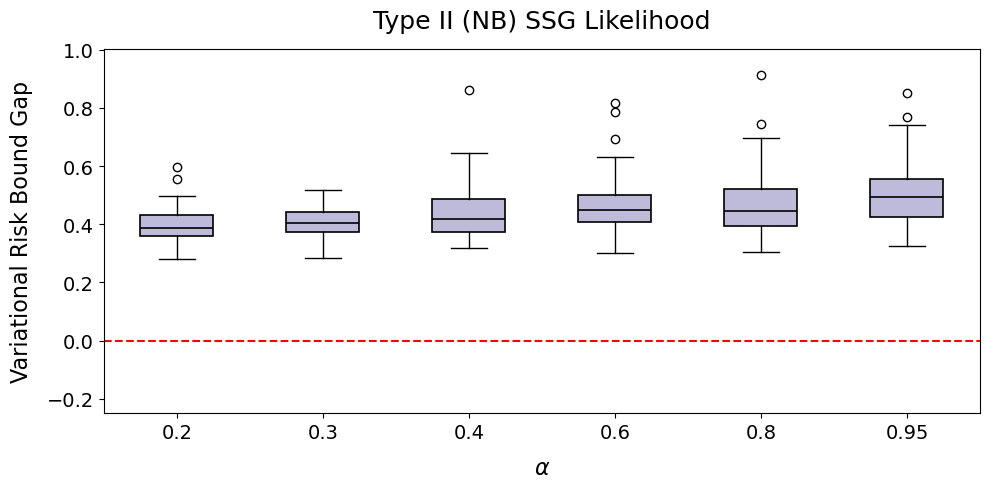

In [98]:
import time

# --------------------------
# User-configurable settings
# --------------------------
nreps  = 50
n      = 2000
n_MC   = 100
p      = 8
r      = 10
alphas = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]
rng    = np.random.default_rng(2025)  # global RNG (reproducible)

# --------------------------
# Helper: one repetition
# --------------------------
def run_one_rep(alpha, n, p, rng):
    """
    Returns a dict with: alpha, integral, bound, runtime_fit, n, p, tau2.
    """
    t0 = time.time()

    # --- Simulate data ---
    beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
    probs = 1 / (1 + np.exp(-linear_term))
    y = np.random.negative_binomial(r, probs, size=n)

    # --- Fit TAVIE Negbin model ---
    t_fit0 = time.time()
    negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)
    negbin_tavie_model.fit(X, y, r=r, alpha = alpha, verbose=False) # fitting the TAVIE model for laplace
    t_fit1 = time.time()
    runtime_fit = t_fit1 - t_fit0

    # --- Extract variational estimates ---
    variational_estimates = negbin_tavie_model.get_variational_estimates()
    # Expected keys: 'm_xi' (mean), 'V_xi' (cov), 'a_xi' (shape-like), 'b_xi' (rate/scale-like)

    # --- Monte Carlo integral ---
    integral = Dalpha_MC_integral_nb(
        variational_estimates['m_xi'],
        variational_estimates['V_xi'],
        alpha=alpha,
        r = r,
        beta0=beta_true,
        XX=X_bbvi,
        N=n_MC,
        rng=rng
    )

    # --- Rényi upper bound (your function) ---
    bound = renyi_upper_bound_nb(X_bbvi, 10, beta_true, 
                                 variational_estimates['m_xi'],  variational_estimates['V_xi'], 
                                 alpha)

    return {
        "alpha": alpha,
        "integral": float(integral),
        "bound": float(bound),
        "runtime_fit": float(runtime_fit),
        "n": n,
        "p": p,
    }

# --------------------------
# Main simulation loop
# --------------------------
records = []
for alpha in alphas:
    for rep in range(1, nreps + 1):
        rec = run_one_rep(alpha, n, p, rng)
        rec["rep"] = rep
        records.append(rec)
        print(f"alpha = {alpha}, rep = {rep}")
results = pd.DataFrame.from_records(records)

# Per-alpha summary
summary = (
    results
    .groupby("alpha", as_index=False)
    .agg(mean_integral=("integral", "mean"),
         sd_integral=("integral", "std"),
         mean_bound=("bound", "mean"),
         sd_bound=("bound", "std"),
         mean_runtime_fit=("runtime_fit", "mean"))
    .sort_values("alpha")
)

# (Optional) print a compact report
print("\nPer-alpha summary:")
print(summary.to_string(index=False))

# You now have:
# - 'results': one row per rep per alpha
# - 'summary': averages and std devs by alpha

results.to_pickle(f"results_theory/results_NB_theory_alpha_less_1_n_{n}_p_{p}.pkl")
summary.to_pickle(f"results_theory/summary_NB_theory_alpha_less_1_n_{n}_p_{p}.pkl")


df = results.copy()
df["diff"] = df["bound"] - df["integral"]

# Sort alphas for consistent ordering
alphas = np.sort(df["alpha"].unique())
data_by_alpha = [df.loc[df["alpha"] == a, "diff"].to_numpy() for a in alphas]

# Font sizes
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data_by_alpha,
    labels=[str(a) for a in alphas],
    showfliers=True,
    patch_artist=True
)

# Light blue fill
for box in bp['boxes']:
    box.set(facecolor="#BEBADA", edgecolor="black", linewidth=1.2)

# Bold black medians
for median in bp['medians']:
    median.set(color="black", linewidth=1.2)

# Red dashed reference line at 0
ax.axhline(0, color="red", linestyle="--", linewidth=1.5)

ymin = min(np.concatenate(data_by_alpha))
ymax = max(np.concatenate(data_by_alpha))
pad = 0.1 * max(abs(ymin), abs(ymax))  # 10% padding
lim = max(abs(ymin), abs(ymax)) + pad
ax.set_ylim(-0.25, lim)

# Axis labels and title with larger fonts
ax.set_xlabel(r"$\alpha$", fontsize=label_fontsize, labelpad=10)
ax.set_ylabel(r"Variational Risk Bound Gap", fontsize=label_fontsize, labelpad=10)
ax.set_title(r"Type II (NB) SSG Likelihood", fontsize=title_fontsize, pad=15)

# Tick label size
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

fig.tight_layout()

# Save figure
fig.savefig(f"results_theory/variational_risk_bound_gap_NB_alpha_less_1_n_{n}_p_{p}.png", dpi=300, bbox_inches='tight')

plt.show()
